In [ ]:
!pip install -q imdb-sqlite

In [ ]:
!pip install -q pycountry

In [1]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [ ]:
%%time
!imdb-sqlite

In [ ]:
 print('hello word')

In [2]:
conn = sqlite3.connect("imdb.db")

In [ ]:
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [ ]:
tabelas.head()

In [ ]:
tabelas = tabelas["Table_Name"].values.tolist()

In [ ]:
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela: ", tabela)
    display(resultado)
    print("-"* 100)
    print("\n")

# 1 - Quais são as categorias de Filmes mais comuns no IMDB?


Quais são os principais tipos(categorias) dos titulos(filmes)?

In [3]:
#Cria a consulta SQL
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [4]:
#Extrai o resultado
resultado1 = pd.read_sql_query(consulta1, conn)

In [5]:
#Visualização do resultado
display(resultado1)

,type,COUNT
0,movie,616578
1,short,880891
2,tvEpisode,6846367
3,tvMiniSeries,44436
4,tvMovie,136894
5,tvPilot,2
6,tvSeries,228678
7,tvShort,10621
8,tvSpecial,37720
9,video,263322


In [6]:
#Calcula o percentual para cada tipo
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [7]:
display(resultado1)

,type,COUNT,percentual
0,movie,616578,6.777677
1,short,880891,9.683113
2,tvEpisode,6846367,75.258058
3,tvMiniSeries,44436,0.488459
4,tvMovie,136894,1.504795
5,tvPilot,2,0.000022
6,tvSeries,228678,2.513722
7,tvShort,10621,0.116750
8,tvSpecial,37720,0.414634
9,video,263322,2.894543


In [8]:
#Criando gráfico com 4 categorias:
#As 3 categorias com mais titulos e 1 categoria com todo o restante

#Dicionario vazio
others = {}

#Filtra o percentual em 5% e soma o total
others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

#Gravando percentual
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

#Ajusta o nome
others['type'] = 'others'

In [9]:
others

{'COUNT': 753352, 'percentual': 8.281152373678548, 'type': 'others'}

In [10]:
display(resultado1)

,type,COUNT,percentual
0,movie,616578,6.777677
1,short,880891,9.683113
2,tvEpisode,6846367,75.258058
3,tvMiniSeries,44436,0.488459
4,tvMovie,136894,1.504795
5,tvPilot,2,0.000022
6,tvSeries,228678,2.513722
7,tvShort,10621,0.116750
8,tvSpecial,37720,0.414634
9,video,263322,2.894543


In [11]:
#Filtra o dataframe de resultado
resultado1 = resultado1[resultado1['percentual'] > 5]

In [12]:
#Append com o dataframe de resultado
resultado1 = resultado1.append(others, ignore_index = True)

In [13]:
#Ordena o resultado
resultado1 = resultado1.sort_values(by = 'COUNT', ascending = False)


In [14]:
#Visualização
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6846367,75.258058
1,short,880891,9.683113
3,others,753352,8.281152
0,movie,616578,6.777677


In [15]:
#Ajusta os labels
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i], 2)) +'%'+']'for i in resultado1.index]

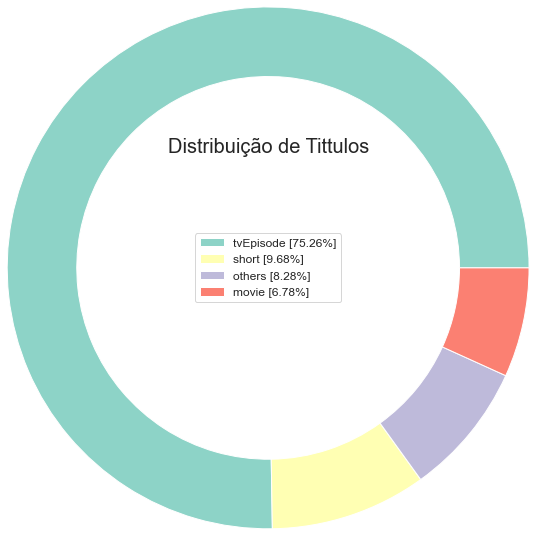

In [16]:
#Plot

#Mapa de cores
cs = cm.Set3(np.arange(100))

#Cria a figura
f = plt.figure()

#Pie Plot
plt.pie(resultado1['COUNT'],labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size': 12})
plt.title('Distribuição de Tittulos', loc = 'Center', fontdict = {'fontsize':20, 'fontweight':20})
plt.show()

# 2 - Qual número de titulos por Gênero ?


Vamos calcular o numero de filmes por genero e entregar o resultado em valor percentual

In [17]:
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

In [18]:
resultado2 = pd.read_sql_query(consulta2, conn)

In [19]:
display(resultado2)

,genres,COUNT(*)
0,Action,14119
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",6
4,"Action,Adult,Crime",10
...,...,...
1463,"Thriller,Western",43
1464,War,1307
1465,"War,Western",14
1466,Western,5095


In [20]:
resultado2['genres'] = resultado2['genres'].str.lower().values

In [21]:
temp = resultado2['genres'].dropna()

In [22]:
display(resultado2)

,genres,COUNT(*)
0,action,14119
1,"action,adult",11
2,"action,adult,adventure",2
3,"action,adult,comedy",6
4,"action,adult,crime",10
...,...,...
1463,"thriller,western",43
1464,war,1307
1465,"war,western",14
1466,western,5095


In [23]:
padrao = '(?u)\\b[\\w-]+\\b'

In [24]:
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [25]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [26]:
bag_generos = vetor.transform(temp)

In [27]:
generos_unicos = vetor.get_feature_names()

In [28]:
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [29]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1468 entries, 0 to 1467
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1468 non-null   int64
 1   adult        1468 non-null   int64
 2   adventure    1468 non-null   int64
 3   animation    1468 non-null   int64
 4   biography    1468 non-null   int64
 5   comedy       1468 non-null   int64
 6   crime        1468 non-null   int64
 7   documentary  1468 non-null   int64
 8   drama        1468 non-null   int64
 9   family       1468 non-null   int64
 10  fantasy      1468 non-null   int64
 11  film-noir    1468 non-null   int64
 12  game-show    1468 non-null   int64
 13  history      1468 non-null   int64
 14  horror       1468 non-null   int64
 15  music        1468 non-null   int64
 16  musical      1468 non-null   int64
 17  mystery      1468 non-null   int64
 18  n            1468 non-null   int64
 19  news         1468 non-null   int64
 20  reality-

In [30]:
generos = generos.drop(columns = 'n', axis = 0)

In [31]:
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]


In [32]:
generos_percentual.head(10)

drama          17.915531
comedy         16.961853
documentary    15.803815
adventure      14.918256
action         14.509537
romance        13.283379
crime          13.010899
mystery        12.397820
thriller       12.261580
horror         12.193460
dtype: float64

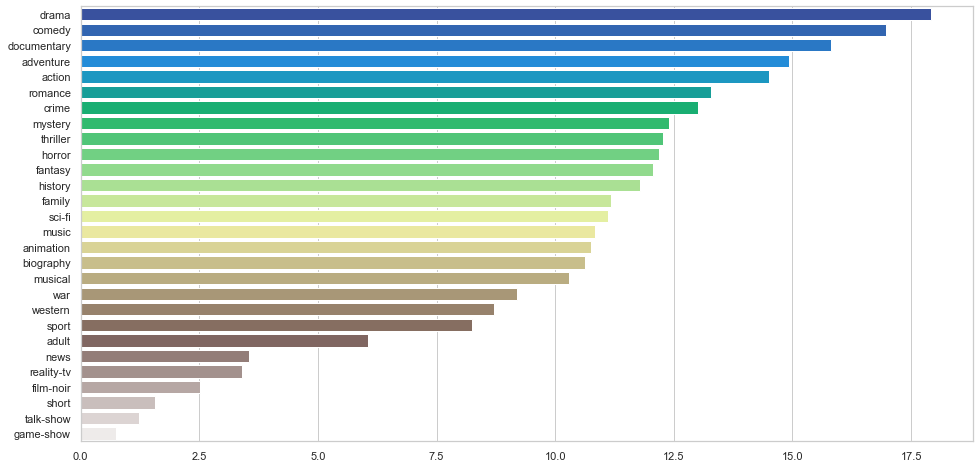

In [33]:
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel = ('Gênero')             
plt.xlabel = ("\nPercentual de Filmes (%)")
plt.title = ('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()